In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import requests
def get_data(token,exchange="coinbase-pro"):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ["ETH","SOL","AVAX","USDT","FLOW"]
exchanges = ["coinbase-pro","coinbase-pro","coinbase-pro","coinbase-pro","kraken"]
dfs = [get_data(token,exchange) for token,exchange in zip(tokens,exchanges)]

In [4]:
df = pd.concat(dfs)
df

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH
...,...,...,...,...,...,...,...,...
510,2021-12-13 06:00:00,9.029,9.080,9.007,9.080,2374.217414,2.145601e+04,FLOW
511,2021-12-13 07:00:00,9.082,9.089,8.994,8.996,1793.663902,1.619684e+04,FLOW
512,2021-12-13 08:00:00,8.994,9.048,8.938,8.942,14916.123880,1.341617e+05,FLOW
513,2021-12-13 09:00:00,8.948,9.012,8.927,9.012,4606.051409,4.137125e+04,FLOW


In [5]:
df.groupby("token")["volumeUSD"].sum().sort_values(ascending=False)

token
ETH     1.985953e+10
SOL     6.511494e+09
AVAX    3.299145e+09
USDT    1.903159e+09
FLOW    8.250270e+07
Name: volumeUSD, dtype: float64

In [6]:
ratio = df.groupby("ts").apply(lambda x:x[x['token']=='ETH']['close']/x[x['token']=='SOL']['close'])
ratio = ratio.reset_index().drop("level_1",axis=1).set_index("ts") # set "ts" as the index for the future join
ratio.rename(columns={"close":"ETH_SOL_ratio"},inplace=True)
df = df.join(ratio,on='ts') 

In [7]:
df

,ts,open,high,low,close,volume,volumeUSD,token,ETH_SOL_ratio
0,2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH,18.891059
...,...,...,...,...,...,...,...,...,...
510,2021-12-13 06:00:00,9.029,9.080,9.007,9.080,2374.217414,2.145601e+04,FLOW,24.177016
511,2021-12-13 07:00:00,9.082,9.089,8.994,8.996,1793.663902,1.619684e+04,FLOW,24.204268
512,2021-12-13 08:00:00,8.994,9.048,8.938,8.942,14916.123880,1.341617e+05,FLOW,24.294354
513,2021-12-13 09:00:00,8.948,9.012,8.927,9.012,4606.051409,4.137125e+04,FLOW,24.232980


In [8]:
df.rename(columns={"volume":"volumeBase","volumeUSE":"volumeTerm"},inplace=True)
df

,ts,open,high,low,close,volumeBase,volumeUSD,token,ETH_SOL_ratio
0,2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH,18.891059
...,...,...,...,...,...,...,...,...,...
510,2021-12-13 06:00:00,9.029,9.080,9.007,9.080,2374.217414,2.145601e+04,FLOW,24.177016
511,2021-12-13 07:00:00,9.082,9.089,8.994,8.996,1793.663902,1.619684e+04,FLOW,24.204268
512,2021-12-13 08:00:00,8.994,9.048,8.938,8.942,14916.123880,1.341617e+05,FLOW,24.294354
513,2021-12-13 09:00:00,8.948,9.012,8.927,9.012,4606.051409,4.137125e+04,FLOW,24.232980


In [9]:
fat_table = df.pivot(index="ts",columns="token",values="close")
fat_table

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,128.67,4262.99,14.150,230.785,1.0012
2021-11-22 01:00:00,134.85,4234.37,13.621,226.000,1.0013
2021-11-22 02:00:00,132.54,4217.89,13.753,227.037,1.0012
2021-11-22 03:00:00,133.38,4193.47,13.652,223.117,1.0011
2021-11-22 04:00:00,136.29,4168.35,13.581,220.652,1.0009
...,...,...,...,...,...
2021-12-13 06:00:00,87.91,4041.43,9.080,167.160,1.0006
2021-12-13 07:00:00,84.98,3992.01,8.996,164.930,1.0006
2021-12-13 08:00:00,84.59,3988.89,8.942,164.190,1.0004


In [10]:
ret = np.log(fat_table).diff(1)
ret

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,0.046912,-0.006736,-0.038102,-0.020952,0.0001
2021-11-22 02:00:00,-0.017279,-0.003900,0.009644,0.004578,-0.0001
2021-11-22 03:00:00,0.006318,-0.005806,-0.007371,-0.017417,-0.0001
2021-11-22 04:00:00,0.021583,-0.006008,-0.005214,-0.011109,-0.0002
...,...,...,...,...,...
2021-12-13 06:00:00,-0.001023,0.005292,0.006408,-0.001972,0.0000
2021-12-13 07:00:00,-0.033898,-0.012304,-0.009294,-0.013430,0.0000
2021-12-13 08:00:00,-0.004600,-0.000782,-0.006021,-0.004497,-0.0002


In [11]:
# the return correlation between different tokens
ret.corr()

token,AVAX,ETH,FLOW,SOL,USDT
token,,,,,
AVAX,1.000000,0.638505,0.382561,0.619588,-0.015231
ETH,0.638505,1.000000,0.557039,0.734564,-0.116529
FLOW,0.382561,0.557039,1.000000,0.439284,-0.197362
SOL,0.619588,0.734564,0.439284,1.000000,0.112016
USDT,-0.015231,-0.116529,-0.197362,0.112016,1.000000


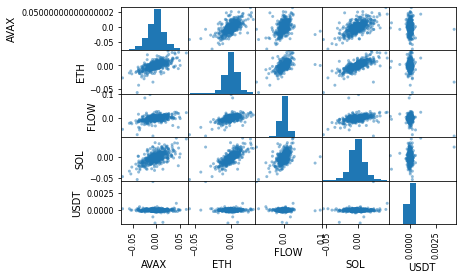

In [12]:
from pandas.plotting import scatter_matrix
scatter_matrix(ret)
plt.show()

<AxesSubplot:xlabel='token', ylabel='token'>

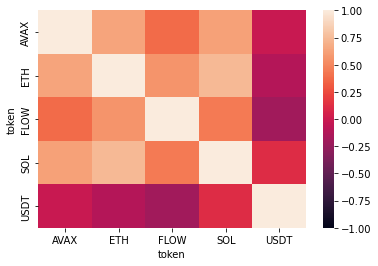

In [16]:
import seaborn
seaborn.heatmap(ret.corr(),vmin=-1,vmax=1)